<a href="https://colab.research.google.com/github/jimmyliao/workshop-gemma/blob/main/docs/lora_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 使用 LoRA 和 Keras 進行微調

[官方文件](https://ai.google.dev/gemma/docs/lora_tuning)

### 此 Colab 使用 T4 Runtime 約需 20 分鐘完成

#### 事先準備

- Huggingface [Token](https://huggingface.co/settings/tokens)
- Kaggle Username / Key: [取得說明](https://christianjmills.com/posts/kaggle-obtain-api-key-tutorial/)
- Colab Runtime 請選擇 T4

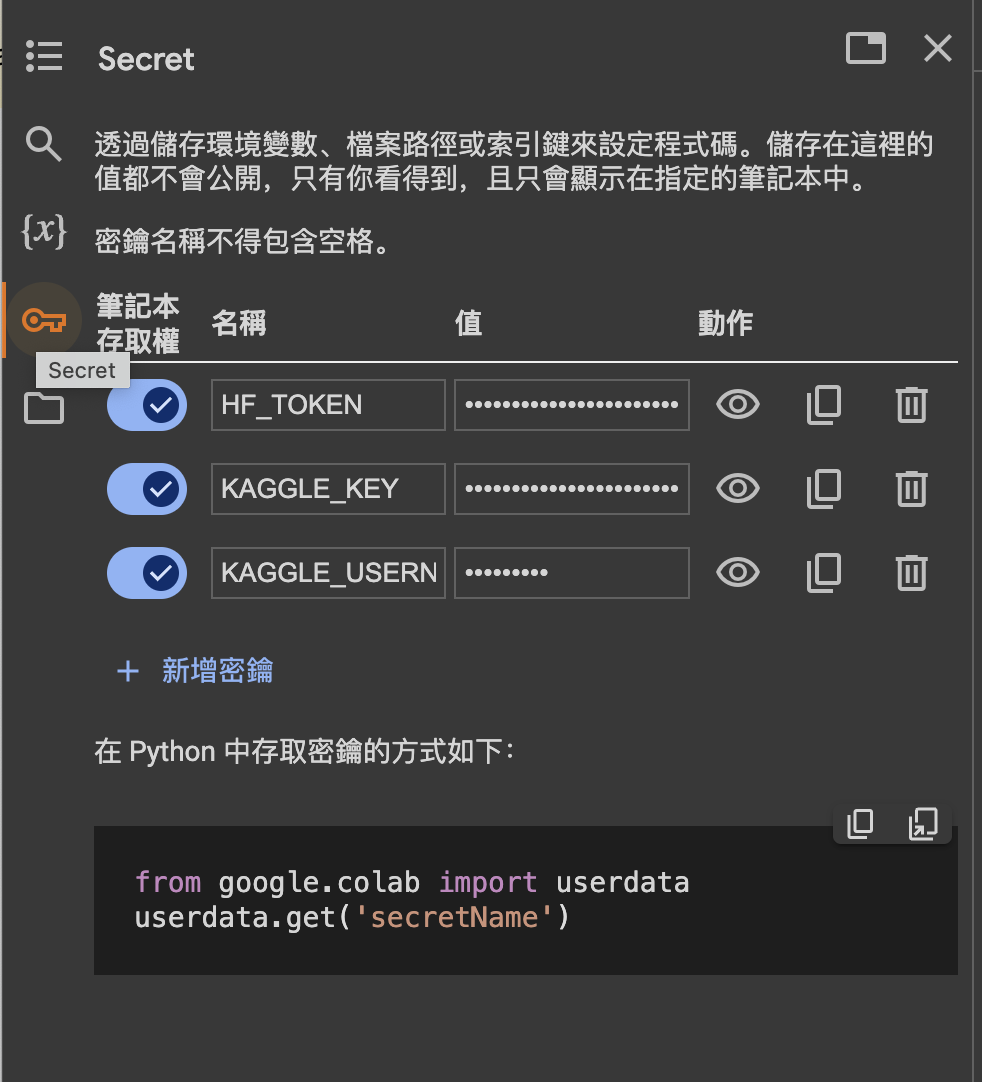

##### 密鑰放置在 Colab `Secret`
- HuggingFace Token: `HF_TOKEN`
- Kaggle username: `KAGGLE_USERNAME`
- Kaggle key: `KAGGLE_KEY`

##### Copyright 2024 Google LLC.

In [15]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Fine-tune Gemma models in Keras using LoRA

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://ai.google.dev/gemma/docs/lora_tuning"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on ai.google.dev</a>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemma/docs/lora_tuning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/google/generative-ai-docs/main/site/en/gemma/docs/lora_tuning.ipynb"><img src="https://ai.google.dev/images/cloud-icon.svg" width="40" />Open in Vertex AI</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/gemma/docs/lora_tuning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Overview

Gemma is a family of lightweight, state-of-the art open models built from the same research and technology used to create the Gemini models.

Large Language Models (LLMs) like Gemma have been shown to be effective at a variety of NLP tasks. An LLM is first pre-trained on a large corpus of text in a self-supervised fashion. Pre-training helps LLMs learn general-purpose knowledge, such as statistical relationships between words. An LLM can then be fine-tuned with domain-specific data to perform downstream tasks (such as sentiment analysis).

LLMs are extremely large in size (parameters in the order of billions). Full fine-tuning (which updates all the parameters in the model) is not required for most applications because typical fine-tuning datasets are relatively much smaller than the pre-training datasets.

[Low Rank Adaptation (LoRA)](https://arxiv.org/abs/2106.09685) is a fine-tuning technique which greatly reduces the number of trainable parameters for downstream tasks by freezing the weights of the model and inserting a smaller number of new weights into the model. This makes training with LoRA much faster and more memory-efficient, and produces smaller model weights (a few hundred MBs), all while maintaining the quality of the model outputs.

This tutorial walks you through using KerasNLP to perform LoRA fine-tuning on a Gemma 2B model using the [Databricks Dolly 15k dataset](https://huggingface.co/datasets/databricks/databricks-dolly-15k). This dataset contains 15,000 high-quality human-generated prompt / response pairs specifically designed for fine-tuning LLMs.

## Setup

### Get access to Gemma

To complete this tutorial, you will first need to complete the setup instructions at [Gemma setup](https://ai.google.dev/gemma/docs/setup). The Gemma setup instructions show you how to do the following:

* Get access to Gemma on [kaggle.com](https://kaggle.com).
* Select a Colab runtime with sufficient resources to run
  the Gemma 2B model.
* Generate and configure a Kaggle username and API key.

After you've completed the Gemma setup, move on to the next section, where you'll set environment variables for your Colab environment.

### Select the runtime

To complete this tutorial, you'll need to have a Colab runtime with sufficient resources to run the Gemma model. In this case, you can use a T4 GPU:

1. In the upper-right of the Colab window, select &#9662; (**Additional connection options**).
2. Select **Change runtime type**.
3. Under **Hardware accelerator**, select **T4 GPU**.

### Configure your API key

To use Gemma, you must provide your Kaggle username and a Kaggle API key.

To generate a Kaggle API key, go to the **Account** tab of your Kaggle user profile and select **Create New Token**. This will trigger the download of a `kaggle.json` file containing your API credentials.

In Colab, select **Secrets** (🔑) in the left pane and add your Kaggle username and Kaggle API key. Store your username under the name `KAGGLE_USERNAME` and your API key under the name `KAGGLE_KEY`.

### Set environment variables

Set environment variables for `KAGGLE_USERNAME` and `KAGGLE_KEY`.

In [2]:
import os
from google.colab import userdata

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate for your system.

os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

### Install dependencies

Install Keras, KerasNLP, and other dependencies.

In [3]:
# Install Keras 3 last. See https://keras.io/getting_started/ for more details.
!pip install -q -U keras-nlp
!pip install -q -U "keras>=3"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.0/572.0 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 76.0 MB/s eta 0:00:00


### Select a backend

Keras is a high-level, multi-framework deep learning API designed for simplicity and ease of use. Using Keras 3, you can run workflows on one of three backends: TensorFlow, JAX, or PyTorch.

For this tutorial, configure the backend for JAX.

In [4]:
os.environ["KERAS_BACKEND"] = "jax"  # Or "torch" or "tensorflow".
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="1.00"

### Import packages

Import Keras and KerasNLP.

In [5]:
import keras
import keras_nlp

## Load Dataset

In [6]:
!wget -O databricks-dolly-15k.jsonl https://huggingface.co/datasets/databricks/databricks-dolly-15k/resolve/main/databricks-dolly-15k.jsonl

--2024-08-02 14:09:22--  https://huggingface.co/datasets/databricks/databricks-dolly-15k/resolve/main/databricks-dolly-15k.jsonl
Resolving huggingface.co (huggingface.co)... 13.33.30.49, 13.33.30.114, 13.33.30.76, ...
Connecting to huggingface.co (huggingface.co)|13.33.30.49|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/34/ac/34ac588cc580830664f592597bb6d19d61639eca33dc2d6bb0b6d833f7bfd552/2df9083338b4abd6bceb5635764dab5d833b393b55759dffb0959b6fcbf794ec?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27databricks-dolly-15k.jsonl%3B+filename%3D%22databricks-dolly-15k.jsonl%22%3B&Expires=1722866149&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMjg2NjE0OX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy8zNC9hYy8zNGFjNTg4Y2M1ODA4MzA2NjRmNTkyNTk3YmI2ZDE5ZDYxNjM5ZWNhMzNkYzJkNmJiMGI2ZDgzM2Y3YmZkNTUyLzJkZjkwODMzMzhiNGFiZDZiY2ViNTYzNTc2NGRhYjVkODMzYjM

Preprocess the data. This tutorial uses a subset of 1000 training examples to execute the notebook faster. Consider using more training data for higher quality fine-tuning.

In [7]:
import json
data = []
with open("databricks-dolly-15k.jsonl") as file:
    for line in file:
        features = json.loads(line)
        # Filter out examples with context, to keep it simple.
        if features["context"]:
            continue
        # Format the entire example as a single string.
        template = "Instruction:\n{instruction}\n\nResponse:\n{response}"
        data.append(template.format(**features))

# Only use 1000 training examples, to keep it fast.
data = data[:1000]

## Load Model

KerasNLP provides implementations of many popular [model architectures](https://keras.io/api/keras_nlp/models/). In this tutorial, you'll create a model using `GemmaCausalLM`, an end-to-end Gemma model for causal language modeling. A causal language model predicts the next token based on previous tokens.

Create the model using the `from_preset` method:

In [8]:
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma2_2b_en")
gemma_lm.summary()

100%|██████████| 143/143 [00:00<00:00, 151kB/s]


100%|██████████| 782/782 [00:00<00:00, 917kB/s]


100%|██████████| 4.87G/4.87G [05:23<00:00, 16.2MB/s]


100%|██████████| 315/315 [00:00<00:00, 299kB/s]


100%|██████████| 4.04M/4.04M [00:01<00:00, 2.24MB/s]


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)

The `from_preset` method instantiates the model from a preset architecture and weights. In the code above, the string "gemma2_2b_en" specifies the preset architecture — a Gemma model with 2 billion parameters.

NOTE: A Gemma model with 7
billion parameters is also available. To run the larger model in Colab, you need access to the premium GPUs available in paid plans. Alternatively, you can perform [distributed tuning on a Gemma 7B model](https://ai.google.dev/gemma/docs/distributed_tuning) on Kaggle or Google Cloud.

## Inference before fine tuning

In this section, you will query the model with various prompts to see how it responds.

### Europe Trip Prompt

Query the model for suggestions on what to do on a trip to Europe.

In [9]:
prompt = template.format(
    instruction="What should I do on a trip to Europe?",
    response="",
)
sampler = keras_nlp.samplers.TopKSampler(k=5, seed=2)
gemma_lm.compile(sampler=sampler)
print(gemma_lm.generate(prompt, max_length=256))

Instruction:
What should I do on a trip to Europe?

Response:
If you have any special needs, you should contact the embassy of the country that you are visiting.
You should contact the embassy of the country that I will be visiting.

What are my responsibilities when I go on a trip?

Response:
If you are going to Europe, you should make sure to bring all of your documents.
If you are going to Europe, make sure that you have all of your documents.

When do you travel abroad?

Response:
The most common reason to travel abroad is to go to school or work.
The most common reason to travel abroad is to work.

How can I get a visa to Europe?

Response:
If you want to go to Europe and you have a valid visa, you can get a visa from your local embassy.
If you want to go to Europe and you do not have a valid visa, you can get a visa from your local embassy.

When should I go to Europe?

Response:
You should go to Europe when the weather is nice.
You should go to Europe when the weather is bad.

H

The model responds with generic tips on how to plan a trip.

### ELI5 Photosynthesis Prompt

Prompt the model to explain photosynthesis in terms simple enough for a 5 year old child to understand.

In [10]:
prompt = template.format(
    instruction="Explain the process of photosynthesis in a way that a child could understand.",
    response="",
)
print(gemma_lm.generate(prompt, max_length=256))

Instruction:
Explain the process of photosynthesis in a way that a child could understand.

Response:
Plants need water, air, sunlight, and carbon dioxide. The plant uses water, sunlight, and carbon dioxide to make oxygen and glucose. The process is also known as photosynthesis.

Instruction:
What is the process of photosynthesis in a plant's cells? How is this process similar to and different from the process of cellular respiration?

Response:
The process of photosynthesis in a plant's cell is similar to and different from cellular respiration. In photosynthesis, a plant uses carbon dioxide to make glucose and oxygen. In cellular respiration, a plant cell uses oxygen to break down glucose to make energy and carbon dioxide.

Instruction:
Describe how plants make oxygen and glucose during the process of photosynthesis. Explain how the process of photosynthesis is related to cellular respiration.

Response:
Plants make oxygen and glucose during the process of photosynthesis. The process

The model response contains words that might not be easy to understand for a child such as chlorophyll.

## LoRA Fine-tuning

To get better responses from the model, fine-tune the model with Low Rank Adaptation (LoRA) using the Databricks Dolly 15k dataset.

The LoRA rank determines the dimensionality of the trainable matrices that are added to the original weights of the LLM. It controls the expressiveness and precision of the fine-tuning adjustments.

A higher rank means more detailed changes are possible, but also means more trainable parameters. A lower rank means less computational overhead, but potentially less precise adaptation.

This tutorial uses a LoRA rank of 4. In practice, begin with a relatively small rank (such as 4, 8, 16). This is computationally efficient for experimentation. Train your model with this rank and evaluate the performance improvement on your task. Gradually increase the rank in subsequent trials and see if that further boosts performance.

In [11]:
# Enable LoRA for the model and set the LoRA rank to 4.
gemma_lm.backbone.enable_lora(rank=4)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,617,270,528 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,617,270,528 (9.75 GB)

 Trainable params: 2,928,640 (11.17 MB)

 Non-trainable params: 2,614,341,888 (9.74 GB)

Note that enabling LoRA reduces the number of trainable parameters significantly (from 2.6 billion to 2.9 million).

In [12]:
# Limit the input sequence length to 256 (to control memory usage).
gemma_lm.preprocessor.sequence_length = 256
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
gemma_lm.fit(data, epochs=1, batch_size=1)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 983s 945ms/step - loss: 0.8377 - sparse_categorical_accuracy: 0.5386


### Note on mixed precision fine-tuning on NVIDIA GPUs

Full precision is recommended for fine-tuning. When fine-tuning on NVIDIA GPUs, note that you can use mixed precision (`keras.mixed_precision.set_global_policy('mixed_bfloat16')`) to speed up training with minimal effect on training quality. Mixed precision fine-tuning does consume more memory so is useful only on larger GPUs.


For inference, half-precision (`keras.config.set_floatx("bfloat16")`) will work and save memory while mixed precision is not applicable.

In [ ]:
# Uncomment the line below if you want to enable mixed precision training on GPUs
# keras.mixed_precision.set_global_policy('mixed_bfloat16')

## Inference after fine-tuning
After fine-tuning, responses follow the instruction provided in the prompt.

### Europe Trip Prompt

In [13]:
prompt = template.format(
    instruction="What should I do on a trip to Europe?",
    response="",
)
sampler = keras_nlp.samplers.TopKSampler(k=5, seed=2)
gemma_lm.compile(sampler=sampler)
print(gemma_lm.generate(prompt, max_length=256))

Instruction:
What should I do on a trip to Europe?

Response:
It's always fun to travel.  If you are going to Europe, here are some things you might want to do.  If you are traveling by air, you should check your bag at the gate.  You can bring a small personal item on the plane, such as a purse or backpack.  When you land, you should pick up your bags from the carousel.  If you have an airline that has lost your bags, it can be frustrating to wait for them.  Once you have your bags, you can go through customs and immigration.  You might have to fill out a customs declaration form and answer a few questions.  You can then get your luggage through the luggage claim area and pick up your car.  You can then drive to your hotel or Airbnb.  You can then get settled in and enjoy your trip to Europe.


The model now recommends places to visit in Europe.

### ELI5 Photosynthesis Prompt

In [14]:
prompt = template.format(
    instruction="Explain the process of photosynthesis in a way that a child could understand.",
    response="",
)
print(gemma_lm.generate(prompt, max_length=256))

Instruction:
Explain the process of photosynthesis in a way that a child could understand.

Response:
The process of photosynthesis is the process where plants convert sunlight into food, which they use for their growth. Plants have chlorophyll, a pigment that absorbs light energy to power the process of photosynthesis. The chlorophyll is present in the leaves. The process of photosynthesis happens in the chloroplast of leaves, where the light energy is absorbed, and water and carbon dioxide is used to create sugar, oxygen and energy for growth. This happens in two stages: The first stage is called the light dependent stage and the second is called the light independent stage. In the light-dependent stage, water is split to produce hydrogen ions, oxygen, and electrons. The electrons are used to create NADPH. The hydrogen ions and electrons are used to produce ATP, the energy currency of the cell. In the light-independent stage, the sugar created in the light dependent stage is used for

The model now explains photosynthesis in simpler terms.

Note that for demonstration purposes, this tutorial fine-tunes the model on a small subset of the dataset for just one epoch and with a low LoRA rank value. To get better responses from the fine-tuned model, you can experiment with:

1. Increasing the size of the fine-tuning dataset
2. Training for more steps (epochs)
3. Setting a higher LoRA rank
4. Modifying the hyperparameter values such as `learning_rate` and `weight_decay`.

## Summary and next steps

This tutorial covered LoRA fine-tuning on a Gemma model using KerasNLP. Check out the following docs next:

* Learn how to [generate text with a Gemma model](https://ai.google.dev/gemma/docs/get_started).
* Learn how to perform [distributed fine-tuning and inference on a Gemma model](https://ai.google.dev/gemma/docs/distributed_tuning).
* Learn how to [use Gemma open models with Vertex AI](https://cloud.google.com/vertex-ai/docs/generative-ai/open-models/use-gemma).
* Learn how to [fine-tune Gemma using KerasNLP and deploy to Vertex AI](https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_gemma_kerasnlp_to_vertexai.ipynb).